<a href="https://colab.research.google.com/github/jamesemansfield2/finance_transactions_fraud_genai_llm_prompt_codewriter_output/blob/main/Fraud_Coder_genai_llm_prompt_write_code_output_20250914v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fraud_code_writer — Prompt→Code for ATM/Mobile/POS/Web
What this does:
Takes a dataset of transactions across ATM, Mobile, POS, Web and lets a Gen‑AI code writer (Gemini) generate Python on demand to produce summaries and charts.
This notebook stays minimal and clean: you set a path, give a prompt, review generated code, then run it.

Flow

Setup (paths, API key)
Load & map your data columns
Basic clean/normalize (timestamps, channels, amounts, labels)
Prompt → Generate code with Gemini (saved to file)
Run generated code (after you review it)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This cell is no longer needed as cell gYbwxEysV9kG handles the API key input securely.

In [3]:
# 1) Install deps (you may be prompted to restart the runtime after this)
!pip -q install google-genai gradio pandas numpy matplotlib scikit-learn kaggle


In [4]:
# 2) Set GEMINI_API_KEY (hidden prompt if not already set in env)
import os
if not os.getenv("GEMINI_API_KEY"):
    try:
        from getpass import getpass
        os.environ["GEMINI_API_KEY"] = getpass("Enter GEMINI_API_KEY (input hidden): ").strip()
    except Exception:
        os.environ["GEMINI_API_KEY"] = input("Enter GEMINI_API_KEY: ").strip()
print("GEMINI_API_KEY set ✅")


Enter GEMINI_API_KEY (input hidden): ··········
GEMINI_API_KEY set ✅


In [7]:
from pathlib import Path
import pandas as pd

# Set the CSV path (spaces in folder names are fine)
csv_path = Path("/content/drive/MyDrive/1 Career/code_writer_fraud/financial_fraud_detection_dataset.csv")

# Optional: sanity check
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found at: {csv_path}")

# Read first 10,000 rows (with a safe fallback for encoding quirks)
try:
    df = pd.read_csv(csv_path, nrows=100000)
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, nrows=100000, encoding="latin-1", engine="python")

print(f"Loaded {csv_path.name} → df.shape = {df.shape}")
df.head()


Loaded financial_fraud_detection_dataset.csv → df.shape = (100000, 18)


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,NaN,NaN,-1.78,20,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,False,NaN,NaN,-0.60,6,0.37,wire_transfer,107.136.36.87,D9961380
4,T100004,2023-09-24T08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13,0.27,ACH,108.161.108.255,D7637601


### Generated code

fraud_rate_by_device = df.groupby('device_used')['is_fraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
fraud_rate_by_device.plot(kind='bar')
plt.title('Fraud Rate by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Fraud rate by device type:")
print(fraud_rate_by_device)

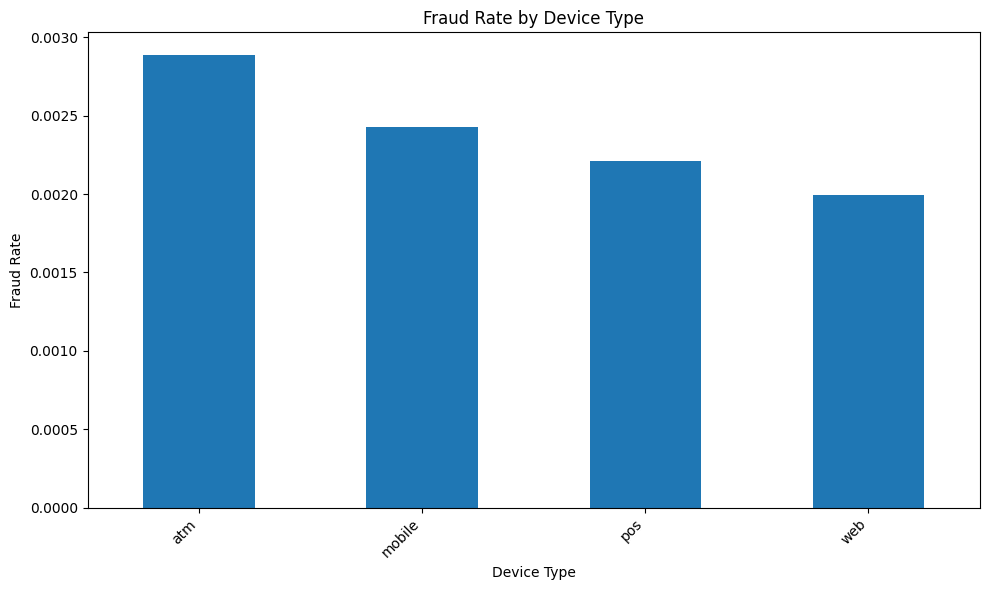

### Output

Fraud rate by device type:
device_used
atm       0.002888
mobile    0.002428
pos       0.002209
web       0.001996
Name: is_fraud, dtype: float64


In [8]:
# === Generate code with Gemini 2.5 Flash, display it, run it safely, display outputs & plots ===

from __future__ import annotations

import os, io, re, json, signal, textwrap, traceback
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict, Any
from contextlib import redirect_stdout, redirect_stderr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty display
from IPython.display import display, Markdown, Code

# ---- Preconditions: df must already exist ----
assert 'df' in globals() and isinstance(df, pd.DataFrame) and len(df) > 0, \
    "`df` not found or empty. Load your CSV into a DataFrame named `df` first."

# ---- Your analysis request (edit this) ----
USER_REQUEST = "Show fraud rate by device_type as a sorted bar chart."

# ---- Gemini imports (install google-genai if needed) ----
try:
    from google import genai
    from google.genai import types as genai_types
except Exception as e:
    raise RuntimeError(
        "google-genai not installed. Run:\n"
        "!pip -qU install google-genai"
    )

# ---- Model & generation config ----
MODEL_NAME = "gemini-2.5-flash"
TEMPERATURE = 0.2
MAX_TOKENS = 4096
THINK_BUDGET = 0  # 0 = disabled thinking for speed

SYSTEM_INSTRUCTION = (
    "You are a Python data analysis assistant for a financial transactions dataset.\n"
    "Return ONLY executable Python code (no backticks, no explanations).\n"
    "Assumptions:\n- A pandas DataFrame named df is already available and contains the dataset.\n"
    "You may use: pandas as pd, numpy as np, matplotlib.pyplot as plt, and scikit-learn (sklearn).\n"
    "Rules:\n- Do NOT read or write files.\n- Do NOT access the network.\n- Do NOT call os, sys, subprocess, or shell commands.\n"
    "Keep outputs concise. Use print() to report KPIs/insights.\n"
    "If you plot, call plt.figure() and create clear axis labels and titles.\n"
    "Prefer interpretable steps (value counts, groupby, rates, ROC-AUC) and handle class imbalance when relevant."
)

def summarize_schema(df: pd.DataFrame, max_cols: int = 60) -> str:
    dtypes = df.dtypes.astype(str).to_dict()
    cols = list(df.columns)
    head = df.head(3).to_dict(orient="records")
    sample = json.dumps(head, ensure_ascii=False)[:2000]
    shown = cols[:max_cols] + (["..."] if len(cols) > max_cols else [])
    return textwrap.dedent(f"""
    Columns ({len(cols)}): {shown}
    Dtypes: {dtypes}
    Sample rows (first 3 as JSON): {sample}
    """).strip()

def build_prompt(user_request: str, df: pd.DataFrame) -> Tuple[str, str]:
    schema = summarize_schema(df)
    contents = (
        f"USER REQUEST:\n{user_request}\n\n"
        f"DATASET SCHEMA CONTEXT:\n{schema}\n\n"
        "Write Python code that uses the existing `df` DataFrame to fulfill the request. "
        "Remember the rules and allowed libraries."
    )
    return SYSTEM_INSTRUCTION, contents

def ask_gemini_for_code(user_request: str, df: pd.DataFrame) -> str:
    client = genai.Client()  # reads GEMINI_API_KEY from env
    system_instruction, contents = build_prompt(user_request, df)
    config = genai_types.GenerateContentConfig(
        system_instruction=system_instruction,
        thinking_config=genai_types.ThinkingConfig(thinking_budget=THINK_BUDGET),
        candidate_count=1,
        max_output_tokens=MAX_TOKENS,
        temperature=TEMPERATURE,
    )
    resp = client.models.generate_content(
        model=MODEL_NAME,
        contents=contents,
        config=config,
    )
    text = (resp.text or "").strip()
    # If the model added fences, extract code inside; otherwise use whole text
    m = re.search(r"```(?:python)?\n(.*?)```", text, flags=re.DOTALL | re.IGNORECASE)
    code = m.group(1).strip() if m else text
    if code.startswith("python"):
        code = code[len("python"):].strip()
    return code

# ---- Safe execution (single-process, with timeout & restricted imports) ----
ALLOWED_IMPORTS = {
    "math", "statistics", "pandas", "numpy", "matplotlib", "sklearn", "itertools", "collections"
}
BANNED_MODULES = {"os","sys","subprocess","shutil","pathlib","pickle","socket","requests","urllib","http","ftplib","ssl"}
BANNED_PATTERNS = [
    r"__import__", r"open\(", r"exec\(", r"eval\(",
    r"subprocess\.", r"system\(", r"popen\(", r"import\s+os\b", r"import\s+sys\b"
]
RUN_TIMEOUT_S = 25

@dataclass
class ExecResult:
    ok: bool
    stdout: str
    stderr: str
    error: Optional[str] = None

def _guard_code(text: str) -> Tuple[bool, str]:
    for pat in BANNED_PATTERNS:
        if re.search(pat, text):
            return False, f"Blocked by safety rule: matches banned pattern: {pat}"
    if "to_csv(" in text or "to_excel(" in text:
        return False, "Blocked: file write attempts are not allowed."
    return True, ""

def run_code_safely(code: str, df: pd.DataFrame) -> ExecResult:
    ok, msg = _guard_code(code)
    if not ok:
        return ExecResult(False, "", msg, error=msg)

    class _Timeout:
        def __init__(self, seconds: int): self.seconds = seconds
        def __enter__(self):
            signal.signal(signal.SIGALRM, lambda *a: (_ for _ in ()).throw(TimeoutError()))
            signal.alarm(self.seconds)
        def __exit__(self, exc_type, exc, tb):
            signal.alarm(0); return False

    import builtins as _builtins
    safe_builtins = {
        "abs": _builtins.abs, "min": _builtins.min, "max": _builtins.max,
        "sum": _builtins.sum, "len": _builtins.len, "range": _builtins.range,
        "print": _builtins.print, "enumerate": _builtins.enumerate,
        "zip": _builtins.zip, "map": _builtins.map, "filter": _builtins.filter,
        "any": _builtins.any, "all": _builtins.all, "sorted": _builtins.sorted,
        "ValueError": _builtins.ValueError, "TypeError": _builtins.TypeError,
        "float": _builtins.float, "int": _builtins.int, "str": _builtins.str,
        "bool": _builtins.bool, "list": _builtins.list, "dict": _builtins.dict,
        "set": _builtins.set, "tuple": _builtins.tuple, "round": _builtins.round,
    }

    # Restrict imports within the executed code
    def _restricted_import(name, globals=None, locals=None, fromlist=(), level=0):
        base = name.split(".")[0]
        if base in BANNED_MODULES:
            raise ImportError(f"Import of '{name}' is not allowed.")
        if base not in ALLOWED_IMPORTS:
            raise ImportError(f"Import '{name}' is not in allowlist. Allowed: {sorted(ALLOWED_IMPORTS)}")
        return __import__(name, globals, locals, fromlist, level)

    safe_builtins["__import__"] = _restricted_import  # type: ignore

    # Exec environment
    g = {"__builtins__": safe_builtins, "pd": pd, "np": np, "plt": plt, "df": df}
    l: Dict[str, Any] = {}

    # Capture outputs
    stdout, stderr = io.StringIO(), io.StringIO()
    try:
        with redirect_stdout(stdout), redirect_stderr(stderr), _Timeout(RUN_TIMEOUT_S):
            exec(code, g, l)
        return ExecResult(True, stdout.getvalue(), stderr.getvalue())
    except TimeoutError:
        return ExecResult(False, "", f"Execution timed out after {RUN_TIMEOUT_S}s.", error="timeout")
    except Exception:
        return ExecResult(False, "", traceback.format_exc(), error="exec_error")
    finally:
        # show any figures inline
        figs = [plt.figure(fid) for fid in plt.get_fignums()]
        for fig in figs:
            display(fig)
        plt.close('all')

# ===== 1) Generate code =====
generated_code = ask_gemini_for_code(USER_REQUEST, df)

# ===== 2) Display code =====
display(Markdown("### Generated code"))
display(Code(generated_code, language='python'))

# ===== 3) Run code safely & display outputs =====
result = run_code_safely(generated_code, df)

if result.ok:
    if result.stdout.strip():
        display(Markdown("### Output"))
        print(result.stdout, end="")
    if result.stderr.strip():
        display(Markdown("### Warnings / stderr"))
        print(result.stderr, end="")
else:
    display(Markdown("### Execution failed"))
    print(result.stderr or result.error or "Unknown error", end="")


In [9]:
# === Ask for user question → generate code (Gemini 2.5 Flash) → display code → run safely → show outputs/plots ===

from __future__ import annotations

import os, io, re, json, signal, textwrap, traceback
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict, Any
from contextlib import redirect_stdout, redirect_stderr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Code

# ---- Preconditions: df must already exist ----
assert 'df' in globals() and isinstance(df, pd.DataFrame) and len(df) > 0, \
    "`df` not found or empty. Load your CSV into a DataFrame named `df` first."

# ---- Get the user's analysis question ----
try:
    USER_REQUEST = input("Enter your analysis request for the dataset: ").strip()
except EOFError:
    USER_REQUEST = ""
if not USER_REQUEST:
    USER_REQUEST = "Show fraud rate by device_type as a sorted bar chart."

# ---- Ensure Gemini SDK & API key ----
try:
    from google import genai
    from google.genai import types as genai_types
except Exception as e:
    raise RuntimeError(
        "google-genai not installed. Run:\n"
        "!pip -qU install google-genai"
    )

if not os.getenv("GEMINI_API_KEY"):
    # Light prompt if key not set yet
    try:
        from getpass import getpass
        os.environ["GEMINI_API_KEY"] = getpass("Enter GEMINI_API_KEY (input hidden): ").strip()
    except Exception:
        os.environ["GEMINI_API_KEY"] = input("Enter GEMINI_API_KEY: ").strip()

MODEL_NAME = "gemini-2.5-flash"
TEMPERATURE = 0.2
MAX_TOKENS = 4096
THINK_BUDGET = 0  # 0 = disabled thinking for speed

SYSTEM_INSTRUCTION = (
    "You are a Python data analysis assistant for a financial transactions dataset.\n"
    "Return ONLY executable Python code (no backticks, no explanations).\n"
    "Assumptions:\n- A pandas DataFrame named df is already available and contains the dataset.\n"
    "You may use: pandas as pd, numpy as np, matplotlib.pyplot as plt, and scikit-learn (sklearn).\n"
    "Rules:\n- Do NOT read or write files.\n- Do NOT access the network.\n- Do NOT call os, sys, subprocess, or shell commands.\n"
    "Keep outputs concise. Use print() to report KPIs/insights.\n"
    "If you plot, call plt.figure() and create clear axis labels and titles.\n"
    "Prefer interpretable steps (value counts, groupby, rates, ROC-AUC) and handle class imbalance when relevant."
)

def summarize_schema(df: pd.DataFrame, max_cols: int = 60) -> str:
    dtypes = df.dtypes.astype(str).to_dict()
    cols = list(df.columns)
    head = df.head(3).to_dict(orient="records")
    sample = json.dumps(head, ensure_ascii=False)[:2000]
    shown = cols[:max_cols] + (["..."] if len(cols) > max_cols else [])
    return textwrap.dedent(f"""
    Columns ({len(cols)}): {shown}
    Dtypes: {dtypes}
    Sample rows (first 3 as JSON): {sample}
    """).strip()

def build_prompt(user_request: str, df: pd.DataFrame) -> Tuple[str, str]:
    schema = summarize_schema(df)
    contents = (
        f"USER REQUEST:\n{user_request}\n\n"
        f"DATASET SCHEMA CONTEXT:\n{schema}\n\n"
        "Write Python code that uses the existing `df` DataFrame to fulfill the request. "
        "Remember the rules and allowed libraries."
    )
    return SYSTEM_INSTRUCTION, contents

def ask_gemini_for_code(user_request: str, df: pd.DataFrame) -> str:
    client = genai.Client()  # reads GEMINI_API_KEY from env
    system_instruction, contents = build_prompt(user_request, df)
    config = genai_types.GenerateContentConfig(
        system_instruction=system_instruction,
        thinking_config=genai_types.ThinkingConfig(thinking_budget=THINK_BUDGET),
        candidate_count=1,
        max_output_tokens=MAX_TOKENS,
        temperature=TEMPERATURE,
    )
    resp = client.models.generate_content(
        model=MODEL_NAME,
        contents=contents,
        config=config,
    )
    text = (resp.text or "").strip()
    m = re.search(r"```(?:python)?\n(.*?)```", text, flags=re.DOTALL | re.IGNORECASE)
    code = m.group(1).strip() if m else text
    if code.startswith("python"):
        code = code[len("python"):].strip()
    return code

# ---- Safe execution (single-process, timeout & restricted imports) ----
ALLOWED_IMPORTS = {
    "math", "statistics", "pandas", "numpy", "matplotlib", "sklearn", "itertools", "collections"
}
BANNED_MODULES = {"os","sys","subprocess","shutil","pathlib","pickle","socket","requests","urllib","http","ftplib","ssl"}
BANNED_PATTERNS = [
    r"__import__", r"open\(", r"exec\(", r"eval\(",
    r"subprocess\.", r"system\(", r"popen\(", r"import\s+os\b", r"import\s+sys\b"
]
RUN_TIMEOUT_S = 25

@dataclass
class ExecResult:
    ok: bool
    stdout: str
    stderr: str
    error: Optional[str] = None

def _guard_code(text: str) -> Tuple[bool, str]:
    for pat in BANNED_PATTERNS:
        if re.search(pat, text):
            return False, f"Blocked by safety rule: matches banned pattern: {pat}"
    if "to_csv(" in text or "to_excel(" in text:
        return False, "Blocked: file write attempts are not allowed."
    return True, ""

def run_code_safely(code: str, df: pd.DataFrame) -> ExecResult:
    ok, msg = _guard_code(code)
    if not ok:
        return ExecResult(False, "", msg, error=msg)

    class _Timeout:
        def __init__(self, seconds: int): self.seconds = seconds
        def __enter__(self):
            signal.signal(signal.SIGALRM, lambda *a: (_ for _ in ()).throw(TimeoutError()))
            signal.alarm(self.seconds)
        def __exit__(self, exc_type, exc, tb):
            signal.alarm(0); return False

    import builtins as _builtins
    safe_builtins = {
        "abs": _builtins.abs, "min": _builtins.min, "max": _builtins.max,
        "sum": _builtins.sum, "len": _builtins.len, "range": _builtins.range,
        "print": _builtins.print, "enumerate": _builtins.enumerate,
        "zip": _builtins.zip, "map": _builtins.map, "filter": _builtins.filter,
        "any": _builtins.any, "all": _builtins.all, "sorted": _builtins.sorted,
        "ValueError": _builtins.ValueError, "TypeError": _builtins.TypeError,
        "float": _builtins.float, "int": _builtins.int, "str": _builtins.str,
        "bool": _builtins.bool, "list": _builtins.list, "dict": _builtins.dict,
        "set": _builtins.set, "tuple": _builtins.tuple, "round": _builtins.round,
    }

    def _restricted_import(name, globals=None, locals=None, fromlist=(), level=0):
        base = name.split(".")[0]
        if base in BANNED_MODULES:
            raise ImportError(f"Import of '{name}' is not allowed.")
        if base not in ALLOWED_IMPORTS:
            raise ImportError(f"Import '{name}' is not in allowlist. Allowed: {sorted(ALLOWED_IMPORTS)}")
        return __import__(name, globals, locals, fromlist, level)

    safe_builtins["__import__"] = _restricted_import  # type: ignore
    g = {"__builtins__": safe_builtins, "pd": pd, "np": np, "plt": plt, "df": df}

    stdout, stderr = io.StringIO(), io.StringIO()
    try:
        with redirect_stdout(stdout), redirect_stderr(stderr), _Timeout(RUN_TIMEOUT_S):
            exec(code, g, {})
        return ExecResult(True, stdout.getvalue(), stderr.getvalue())
    except TimeoutError:
        return ExecResult(False, "", f"Execution timed out after {RUN_TIMEOUT_S}s.", error="timeout")
    except Exception:
        return ExecResult(False, "", traceback.format_exc(), error="exec_error")
    finally:
        figs = [plt.figure(fid) for fid in plt.get_fignums()]
        for fig in figs:
            display(fig)
        plt.close('all')

# ===== 1) Generate code =====
generated_code = ask_gemini_for_code(USER_REQUEST, df)

# ===== 2) Display code =====
display(Markdown("### Generated code"))
display(Code(generated_code, language='python'))

# ===== 3) Run code safely & display outputs =====
result = run_code_safely(generated_code, df)

if result.ok:
    if result.stdout.strip():
        display(Markdown("### Output"))
        print(result.stdout, end="")
    if result.stderr.strip():
        display(Markdown("### Warnings / stderr"))
        print(result.stderr, end="")
else:
    display(Markdown("### Execution failed"))
    print(result.stderr or result.error or "Unknown error", end="")

# average fraud amount for disputed vs non disputed


Enter your analysis request for the dataset: average fraud amount for disputed vs non disputed


### Generated code

df['is_disputed'] = df['is_fraud'].astype(bool)
average_fraud_amount = df.groupby('is_disputed')['amount'].mean()
print("Average fraud amount for disputed vs non-disputed transactions:")
print(average_fraud_amount)

### Output

Average fraud amount for disputed vs non-disputed transactions:
is_disputed
False    357.420245
True     397.088824
Name: amount, dtype: float64


In [11]:
# === Ask for user question → generate code (Gemini 2.5 Flash) → display code → run safely → show outputs/plots ===

from __future__ import annotations

import os, io, re, json, signal, textwrap, traceback
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict, Any
from contextlib import redirect_stdout, redirect_stderr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Code

# ---- Preconditions: df must already exist ----
assert 'df' in globals() and isinstance(df, pd.DataFrame) and len(df) > 0, \
    "`df` not found or empty. Load your CSV into a DataFrame named `df` first."

# ---- Get the user's analysis question ----
try:
    USER_REQUEST = input("Enter your analysis request for the dataset: ").strip()
except EOFError:
    USER_REQUEST = ""
if not USER_REQUEST:
    USER_REQUEST = "Show fraud rate by device_type as a sorted bar chart."

# ---- Ensure Gemini SDK & API key ----
try:
    from google import genai
    from google.genai import types as genai_types
except Exception as e:
    raise RuntimeError(
        "google-genai not installed. Run:\n"
        "!pip -qU install google-genai"
    )

if not os.getenv("GEMINI_API_KEY"):
    # Light prompt if key not set yet
    try:
        from getpass import getpass
        os.environ["GEMINI_API_KEY"] = getpass("Enter GEMINI_API_KEY (input hidden): ").strip()
    except Exception:
        os.environ["GEMINI_API_KEY"] = input("Enter GEMINI_API_KEY: ").strip()

MODEL_NAME = "gemini-2.5-flash"
TEMPERATURE = 0.2
MAX_TOKENS = 4096
THINK_BUDGET = 0  # 0 = disabled thinking for speed

SYSTEM_INSTRUCTION = (
    "You are a Python data analysis assistant for a financial transactions dataset.\n"
    "Return ONLY executable Python code (no backticks, no explanations).\n"
    "Assumptions:\n- A pandas DataFrame named df is already available and contains the dataset.\n"
    "You may use: pandas as pd, numpy as np, matplotlib.pyplot as plt, and scikit-learn (sklearn).\n"
    "Rules:\n- Do NOT read or write files.\n- Do NOT access the network.\n- Do NOT call os, sys, subprocess, or shell commands.\n"
    "Keep outputs concise. Use print() to report KPIs/insights.\n"
    "If you plot, call plt.figure() and create clear axis labels and titles.\n"
    "Prefer interpretable steps (value counts, groupby, rates, ROC-AUC) and handle class imbalance when relevant."
)

def summarize_schema(df: pd.DataFrame, max_cols: int = 60) -> str:
    dtypes = df.dtypes.astype(str).to_dict()
    cols = list(df.columns)
    head = df.head(3).to_dict(orient="records")
    sample = json.dumps(head, ensure_ascii=False)[:2000]
    shown = cols[:max_cols] + (["..."] if len(cols) > max_cols else [])
    return textwrap.dedent(f"""
    Columns ({len(cols)}): {shown}
    Dtypes: {dtypes}
    Sample rows (first 3 as JSON): {sample}
    """).strip()

def build_prompt(user_request: str, df: pd.DataFrame) -> Tuple[str, str]:
    schema = summarize_schema(df)
    contents = (
        f"USER REQUEST:\n{user_request}\n\n"
        f"DATASET SCHEMA CONTEXT:\n{schema}\n\n"
        "Write Python code that uses the existing `df` DataFrame to fulfill the request. "
        "Remember the rules and allowed libraries."
    )
    return SYSTEM_INSTRUCTION, contents

def ask_gemini_for_code(user_request: str, df: pd.DataFrame) -> str:
    client = genai.Client()  # reads GEMINI_API_KEY from env
    system_instruction, contents = build_prompt(user_request, df)
    config = genai_types.GenerateContentConfig(
        system_instruction=system_instruction,
        thinking_config=genai_types.ThinkingConfig(thinking_budget=THINK_BUDGET),
        candidate_count=1,
        max_output_tokens=MAX_TOKENS,
        temperature=TEMPERATURE,
    )
    resp = client.models.generate_content(
        model=MODEL_NAME,
        contents=contents,
        config=config,
    )
    text = (resp.text or "").strip()
    m = re.search(r"```(?:python)?\n(.*?)```", text, flags=re.DOTALL | re.IGNORECASE)
    code = m.group(1).strip() if m else text
    if code.startswith("python"):
        code = code[len("python"):].strip()
    return code

# ---- Safe execution (single-process, timeout & restricted imports) ----
ALLOWED_IMPORTS = {
    "math", "statistics", "pandas", "numpy", "matplotlib", "sklearn", "itertools", "collections"
}
BANNED_MODULES = {"os","sys","subprocess","shutil","pathlib","pickle","socket","requests","urllib","http","ftplib","ssl"}
BANNED_PATTERNS = [
    r"__import__", r"open\(", r"exec\(", r"eval\(",
    r"subprocess\.", r"system\(", r"popen\(", r"import\s+os\b", r"import\s+sys\b"
]
RUN_TIMEOUT_S = 25

@dataclass
class ExecResult:
    ok: bool
    stdout: str
    stderr: str
    error: Optional[str] = None

def _guard_code(text: str) -> Tuple[bool, str]:
    for pat in BANNED_PATTERNS:
        if re.search(pat, text):
            return False, f"Blocked by safety rule: matches banned pattern: {pat}"
    if "to_csv(" in text or "to_excel(" in text:
        return False, "Blocked: file write attempts are not allowed."
    return True, ""

def run_code_safely(code: str, df: pd.DataFrame) -> ExecResult:
    ok, msg = _guard_code(code)
    if not ok:
        return ExecResult(False, "", msg, error=msg)

    class _Timeout:
        def __init__(self, seconds: int): self.seconds = seconds
        def __enter__(self):
            signal.signal(signal.SIGALRM, lambda *a: (_ for _ in ()).throw(TimeoutError()))
            signal.alarm(self.seconds)
        def __exit__(self, exc_type, exc, tb):
            signal.alarm(0); return False

    import builtins as _builtins
    safe_builtins = {
        "abs": _builtins.abs, "min": _builtins.min, "max": _builtins.max,
        "sum": _builtins.sum, "len": _builtins.len, "range": _builtins.range,
        "print": _builtins.print, "enumerate": _builtins.enumerate,
        "zip": _builtins.zip, "map": _builtins.map, "filter": _builtins.filter,
        "any": _builtins.any, "all": _builtins.all, "sorted": _builtins.sorted,
        "ValueError": _builtins.ValueError, "TypeError": _builtins.TypeError,
        "float": _builtins.float, "int": _builtins.int, "str": _builtins.str,
        "bool": _builtins.bool, "list": _builtins.list, "dict": _builtins.dict,
        "set": _builtins.set, "tuple": _builtins.tuple, "round": _builtins.round,
    }

    def _restricted_import(name, globals=None, locals=None, fromlist=(), level=0):
        base = name.split(".")[0]
        if base in BANNED_MODULES:
            raise ImportError(f"Import of '{name}' is not allowed.")
        if base not in ALLOWED_IMPORTS:
            raise ImportError(f"Import '{name}' is not in allowlist. Allowed: {sorted(ALLOWED_IMPORTS)}")
        return __import__(name, globals, locals, fromlist, level)

    safe_builtins["__import__"] = _restricted_import  # type: ignore
    g = {"__builtins__": safe_builtins, "pd": pd, "np": np, "plt": plt, "df": df}

    stdout, stderr = io.StringIO(), io.StringIO()
    try:
        with redirect_stdout(stdout), redirect_stderr(stderr), _Timeout(RUN_TIMEOUT_S):
            exec(code, g, {})
        return ExecResult(True, stdout.getvalue(), stderr.getvalue())
    except TimeoutError:
        return ExecResult(False, "", f"Execution timed out after {RUN_TIMEOUT_S}s.", error="timeout")
    except Exception:
        return ExecResult(False, "", traceback.format_exc(), error="exec_error")
    finally:
        figs = [plt.figure(fid) for fid in plt.get_fignums()]
        for fig in figs:
            display(fig)
        plt.close('all')

# ===== 1) Generate code =====
generated_code = ask_gemini_for_code(USER_REQUEST, df)

# ===== 2) Display code =====
display(Markdown("### Generated code"))
display(Code(generated_code, language='python'))

# ===== 3) Run code safely & display outputs =====
result = run_code_safely(generated_code, df)

if result.ok:
    if result.stdout.strip():
        display(Markdown("### Output"))
        print(result.stdout, end="")
    if result.stderr.strip():
        display(Markdown("### Warnings / stderr"))
        print(result.stderr, end="")
else:
    display(Markdown("### Execution failed"))
    print(result.stderr or result.error or "Unknown error", end="")

# average amount for a disputed transaction vs a non disputed transaction


Enter your analysis request for the dataset: what is the average amount per transaction, number, and total value of disputed vs. non disputed transactions?


### Generated code

dispute_summary = df.groupby('is_disputed')['amount'].agg(['mean', 'count', 'sum'])
dispute_summary.columns = ['average_amount', 'number_of_transactions', 'total_value']
print("Disputed vs. Non-Disputed Transactions Summary:")
print(dispute_summary)

### Output

Disputed vs. Non-Disputed Transactions Summary:
             average_amount  number_of_transactions  total_value
is_disputed                                                     
False            357.420245                   99762  35656958.49
True             397.088824                     238     94507.14


In [ ]:
display(df)